In [467]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

from typing import Tuple, Dict
from collections import defaultdict


sns.set(rc={'figure.figsize':(10,10)})

In [468]:
num_skus = 37

pastry_skus_initial = [f'sku_{index}' for index in range(num_skus)]

optimized = False

divider = 4
contribution_ceil = 80
contribution_floor = 60
contributon_min = 4
contribution_min_potential = 3
max_items_in_core = 10
max_items_in_core_in_exception = 15



def simulate_period_sales(skus:list, divider:int = divider, plot:bool=True) -> Tuple[pd.DataFrame, Dict]:
    """
    Simulate period sales for given skus
    @param skus: list of skus considered for given period
    @param plot: plot graph
    """
    # Shuffle skus
    random.shuffle(skus)
    num_items = len(skus)
    percentage_sales = defaultdict(lambda:0)
    # Determine Sales
    for sku in skus[:-1]:
        percentage_sales[sku] = (random.randint(1, 100-sum(percentage_sales.values())-(num_items-1-len(percentage_sales))))//divider
    percentage_sales[skus[-1]] = 100-sum(percentage_sales.values())
    # Sort and create dataframe
    percentage_sales_sorted = {sku:sale for sku, sale in sorted(percentage_sales.items(), key=lambda x:x[1], reverse=True)}
    sales_df = pd.DataFrame.from_records(list(percentage_sales_sorted.items()),columns=["sku", "% sales"])
    if plot:
        sns.barplot(x=sales_df["sku"], y=sales_df["% sales"], palette="colorblind")
        plt.show()
    return sales_df, percentage_sales_sorted



def add_items_to_core_bucket(bucket:list, percentage_sales_items:list, max_items:int, sales_captured:int) -> int:
    while sales_captured <= contribution_ceil and len(bucket)<=max_items:
        sku, sale = percentage_sales_items[0]
        if sale >= contributon_min:
            percentage_sales_items.pop(0)
            sales_captured += sale
            bucket.append(sku)
        else:
            break
    return sales_captured
    

def add_items_to_potential_bucket(bucket:list,percentage_sales_items:list) -> None:
    for sku, sale in percentage_sales_items:
        if sale >= contribution_min_potential:
            bucket.append(sku)
        else:
            print(f"Dropping {sku} permanently from menu")
    

def bucket(buckets, percentage_sales:dict, is_first_iteration=False) -> Tuple[Dict, int] :
    """
    Bucket SKUs into 3 buckets as explained above based on sales result
    Assume that input percentage sales is sorted
    """
    global optimized
    # Reset experiment and core buckets
    buckets["experiment"] = []
    buckets["core"] = []
    
    sales_captured = 0
    percentage_sales_items = list(percentage_sales.items())
    # Add items to core bucket
    sales_captured = add_items_to_core_bucket(buckets["core"], percentage_sales_items, max_items_in_core, sales_captured)
    # Add additional items to core if required
    if sales_captured < contribution_floor:
        sales_captured = add_items_to_core_bucket(buckets["core"], percentage_sales_items, max_items_in_core_in_exception, sales_captured)
    
    if is_first_iteration:
        # Add all other items to reserve
        buckets["reserve"].extend([sku for sku,_ in percentage_sales_items])
    else:
        # Add items to potential or discard them
        add_items_to_potential_bucket(buckets["potential"], percentage_sales_items)
    
    # Check for untested SKUs
    if not buckets["reserve"]:
        print("Cycle completed.")
        optimized = True
        return buckets, sales_captured
    
    # Pick items randomly from reserve for experoment
    random.shuffle(buckets["reserve"])
    for _ in range(5):
        try:
            buckets["experiment"].append(buckets["reserve"].pop(0))
        except Exception:
            pass
    
    return buckets, sales_captured
    
            
        
def print_items_remaining(buckets) -> None:
    print("\nUpdated Counts")
    for key in buckets:
        print(f"{key}: {len(buckets[key])}")
    print(f"total: {sum(len(buckets[key]) for key in buckets)}")

    
def printdf(buckets) -> pd.DataFrame:
    df = pd.DataFrame({key:pd.Series(value) for key, value in buckets.items()})
    df.loc['Total']= df.apply(lambda x: x.notna().sum(), axis=0)
    df.fillna('', inplace=True)
    return df


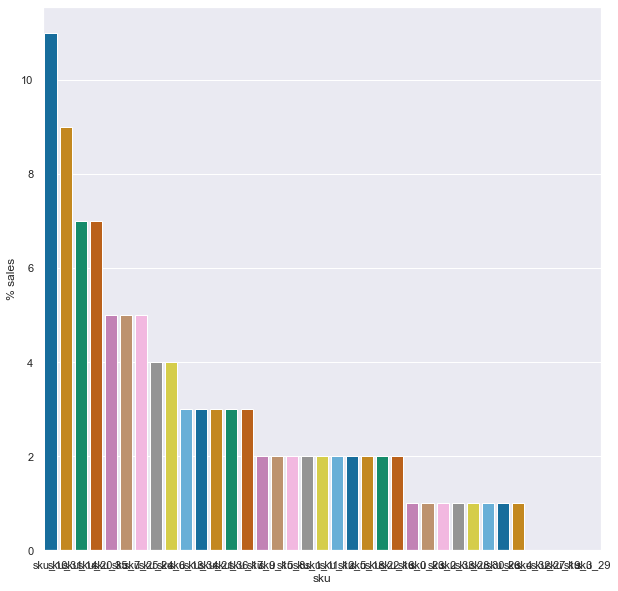

,experiment,core,reserve
0,sku_0,sku_10,sku_2
1,sku_9,sku_31,sku_36
2,sku_12,sku_14,sku_33
3,sku_30,sku_20,sku_8
4,sku_4,sku_35,sku_18
5,,sku_7,sku_22
6,,sku_25,sku_13
7,,sku_24,sku_32
8,,sku_6,sku_23
9,,,sku_3


In [471]:
optimized = False
buckets = defaultdict(lambda: [])
sales_df, percentage_sales = simulate_period_sales(pastry_skus_initial)
buckets, sales_in_core = bucket(buckets, percentage_sales, is_first_iteration=True)
printdf(buckets)

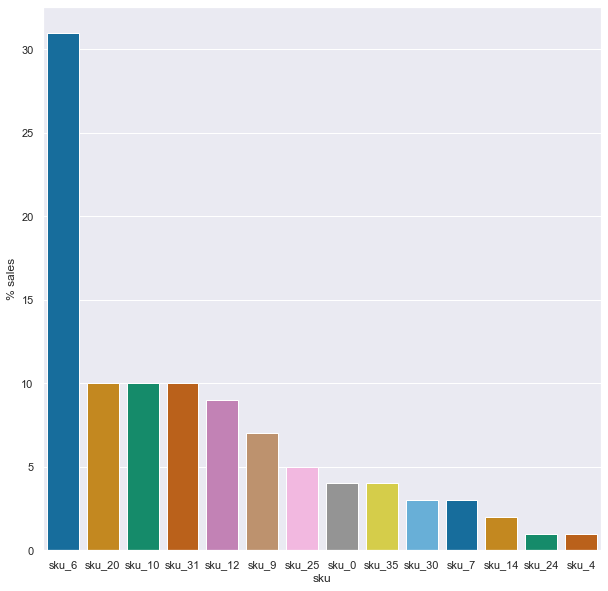

Dropping sku_14 permanently from menu
Dropping sku_24 permanently from menu
Dropping sku_4 permanently from menu

Cumulative sales in Core Bucket: 82


,experiment,core,reserve,potential
0,sku_21,sku_6,sku_2,sku_0
1,sku_26,sku_20,sku_15,sku_35
2,sku_23,sku_10,sku_3,sku_30
3,sku_33,sku_31,sku_28,sku_7
4,sku_11,sku_12,sku_16,
5,,sku_9,sku_18,
6,,sku_25,sku_34,
7,,,sku_19,
8,,,sku_32,
9,,,sku_8,


In [472]:
sales_df, percentage_sales = simulate_period_sales(buckets["core"]+buckets["experiment"])
buckets, sales_in_core = bucket(buckets, percentage_sales, is_first_iteration=False)
print(f'\nCumulative sales in Core Bucket: {sales_in_core}')
printdf(buckets)

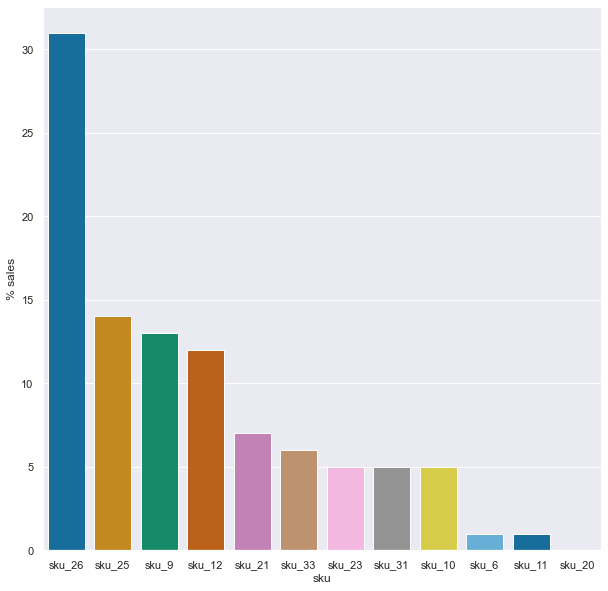

Dropping sku_6 permanently from menu
Dropping sku_11 permanently from menu
Dropping sku_20 permanently from menu

Cumulative sales in Core Bucket: 83


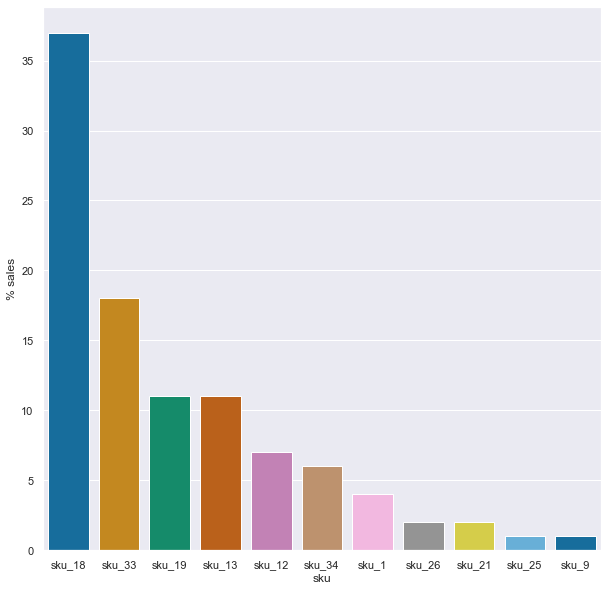

Dropping sku_26 permanently from menu
Dropping sku_21 permanently from menu
Dropping sku_25 permanently from menu
Dropping sku_9 permanently from menu

Cumulative sales in Core Bucket: 84


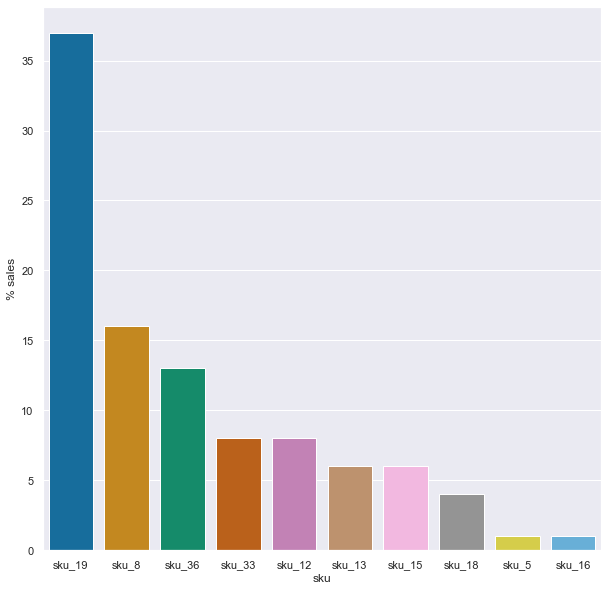

Dropping sku_5 permanently from menu
Dropping sku_16 permanently from menu

Cumulative sales in Core Bucket: 82


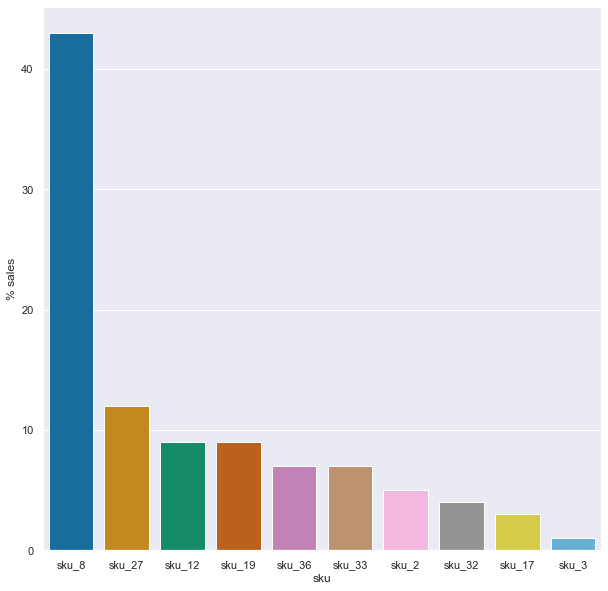

Dropping sku_3 permanently from menu

Cumulative sales in Core Bucket: 87


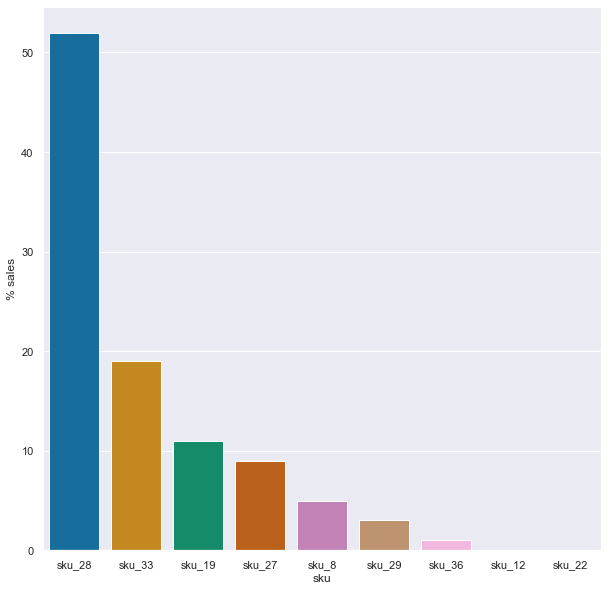

Dropping sku_36 permanently from menu
Dropping sku_12 permanently from menu
Dropping sku_22 permanently from menu
Cycle completed.

Cumulative sales in Core Bucket: 82


/Users/tsharma/WORK/NLTK/lib/python3.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,experiment,core,reserve,potential
0,,sku_28,,sku_0
1,,sku_33,,sku_35
2,,sku_19,,sku_30
3,,,,sku_7
4,,,,sku_23
5,,,,sku_31
6,,,,sku_10
7,,,,sku_34
8,,,,sku_1
9,,,,sku_13


In [473]:
while not optimized:
    sales_df, percentage_sales = simulate_period_sales(buckets["core"]+buckets["experiment"])
    buckets, sales_in_core = bucket(buckets, percentage_sales, is_first_iteration=False)
    print(f'\nCumulative sales in Core Bucket: {sales_in_core}')

printdf(buckets)